In [5]:
import jax
import jax.numpy as jnp

In [8]:
x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [9]:
x

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [10]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

3.38 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
jax.devices()

[cuda(id=0)]

## JAX first transformation: grad

In [12]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [13]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1., 2., 3., 4.]) # JAX requires floating point

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [14]:
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error(x, y))

print(sum_squared_error_dx(x, y))

0.039999947
[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [16]:
# Value of the derivative when calculated by hand
2*(x-y)

Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32)

In [17]:
# gradient w.r.t. both x and y
jax.grad(sum_squared_error, argnums=(0,1))(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [18]:
# gradient w.r.t y only
jax.grad(sum_squared_error, argnums=(1))(x, y)

Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32)

## Value and Grad

In [19]:
jax.value_and_grad(sum_squared_error)(x, y)

(Array(0.03999995, dtype=float32),
 Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

In [20]:
sum_squared_error(x, y)

Array(0.03999995, dtype=float32)

## Auxiliary Data

In [21]:
def squared_error_with_aux(x, y):
    return sum_squared_error(x, y), x-y

In [22]:
jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.03999995, dtype=float32), Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

In [23]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

## Differences from NumPy

In [25]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
    x[0] = 123
    return None

in_place_modify(x)

x

array([123,   2,   3])

In [27]:
# JAX won't allow side effects
# Side effects: any effect of a function that doesn’t appear in its output
in_place_modify(jnp.array(x))

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [28]:
def jax_in_place_modify(x):
    return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

Array([123,   2,   3], dtype=int32)

In [30]:
y # old array untouched, no side effect

Array([1, 2, 3], dtype=int32)

## First JAX Training Loop

In [1]:
import numpy as np
import matplotlib.pyplot as plt

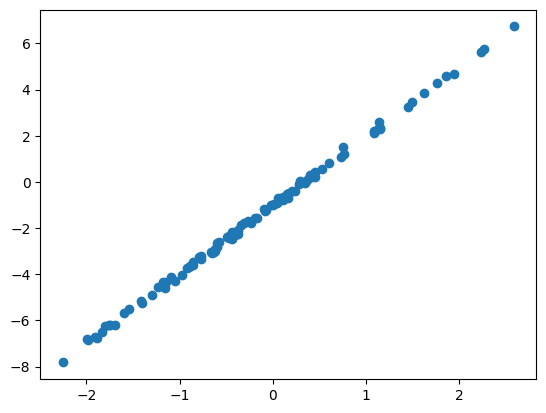

In [4]:
xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [6]:
def model(theta, x): #theta = [w, b]
    w, b = theta
    return w * x + b

def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

In [17]:
@jax.jit
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 2.98, b: -1.00


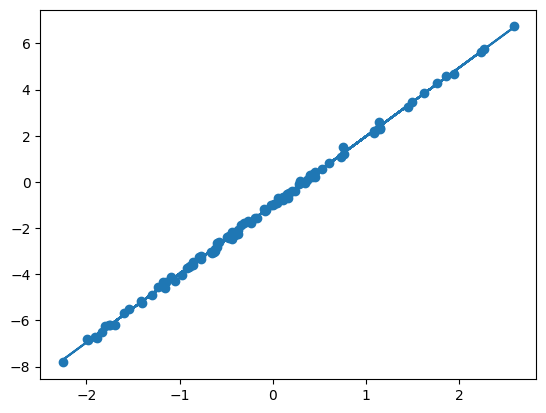

In [18]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")